# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=70,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_18-03-50/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4994 | MulticlassF1Score=0.2081
Batch-30 : CrossEntropyLoss=2.4461 | MulticlassF1Score=0.2692
Batch-45 : CrossEntropyLoss=2.4296 | MulticlassF1Score=0.3054
Batch-60 : CrossEntropyLoss=2.4008 | MulticlassF1Score=0.3501
Batch-75 : CrossEntropyLoss=2.3889 | MulticlassF1Score=0.3848
Batch-90 : CrossEntropyLoss=2.4036 | MulticlassF1Score=0.4060
Batch-105: CrossEntropyLoss=2.4090 | MulticlassF1Score=0.4227
Batch-120: CrossEntropyLoss=2.3880 | MulticlassF1Score=0.4416
Batch-135: CrossEntropyLoss=2.3831 | MulticlassF1Score=0.4576
Batch-150: CrossEntropyLoss=2.3710 | MulticlassF1Score=0.4719
Batch-165: CrossEntropyLoss=2.3649 | MulticlassF1Score=0.4835
Batch-180: CrossEntropyLoss=2.3619 | MulticlassF1Score=0.4931
Batch-195: CrossEntropyLoss=2.3800 | MulticlassF1Score=0.5010
Batch-210: CrossEntropyLoss=2.3684 | MulticlassF1Score=0.5070
Batch-225: CrossEntropyLoss=2.3712 | MulticlassF1Score=0.5126
Batch-226: CrossEntropyLoss=2.3948 | MulticlassF1Score=0.5128

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3436 | MulticlassF1Score=0.6432
Batch-30 : CrossEntropyLoss=2.3614 | MulticlassF1Score=0.6351
Batch-45 : CrossEntropyLoss=2.3731 | MulticlassF1Score=0.6380
Batch-60 : CrossEntropyLoss=2.3905 | MulticlassF1Score=0.6380
Batch-63 : CrossEntropyLoss=2.3760 | MulticlassF1Score=0.6370

Training   : Mean CrossEntropyLoss = 2.4098 | Mean MulticlassF1Score = 0.4036
Validation : Mean CrossEntropyLoss = 2.3654 | Mean MulticlassF1Score = 0.6400

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3465 | MulticlassF1Score=0.6324
Batch-30 : CrossEntropyLoss=2.3578 | MulticlassF1Score=0.6364
Batch-45 : CrossEntropyLoss=2.3543 | MulticlassF1Score=0.6384
Batch-60 : CrossEntropyLoss=2.3339 | MulticlassF1Score=0.6470
Batch-75 : CrossEntropyLoss=2.3373 | MulticlassF1Score=0.6590
Batch-90 : CrossEntropyLoss=2.3408 | MulticlassF1Score=0.6689
Batch-105: CrossEntropyLoss=2.3313 | MulticlassF1Score=0.6754
Batch-120: CrossEntropyLoss=2.3364 | MulticlassF1Score=0.6808
Batch-135: CrossEntropyLoss=2.3395 | MulticlassF1Score=0.6862
Batch-150: CrossEntropyLoss=2.3515 | MulticlassF1Score=0.6894
Batch-165: CrossEntropyLoss=2.3453 | MulticlassF1Score=0.6918
Batch-180: CrossEntropyLoss=2.3417 | MulticlassF1Score=0.6949
Batch-195: CrossEntropyLoss=2.3342 | MulticlassF1Score=0.6967
Batch-210: CrossEntropyLoss=2.3206 | MulticlassF1Score=0.6990
Batch-225: CrossEntropyLoss=2.3250 | MulticlassF1Score=0.7006
Batch-226: CrossEntropyLoss=2.3467 | MulticlassF1Score=0.7007

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3508 | MulticlassF1Score=0.7237
Batch-30 : CrossEntropyLoss=2.3365 | MulticlassF1Score=0.7245
Batch-45 : CrossEntropyLoss=2.3353 | MulticlassF1Score=0.7253
Batch-60 : CrossEntropyLoss=2.3443 | MulticlassF1Score=0.7223
Batch-63 : CrossEntropyLoss=2.3575 | MulticlassF1Score=0.7222

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3414 | Mean MulticlassF1Score = 0.6711
Validation : Mean CrossEntropyLoss = 2.3349 | Mean MulticlassF1Score = 0.7249

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3312 | MulticlassF1Score=0.7319
Batch-30 : CrossEntropyLoss=2.3326 | MulticlassF1Score=0.7252
Batch-45 : CrossEntropyLoss=2.3235 | MulticlassF1Score=0.7232
Batch-60 : CrossEntropyLoss=2.3293 | MulticlassF1Score=0.7234
Batch-75 : CrossEntropyLoss=2.3268 | MulticlassF1Score=0.7250
Batch-90 : CrossEntropyLoss=2.3441 | MulticlassF1Score=0.7239
Batch-105: CrossEntropyLoss=2.3229 | MulticlassF1Score=0.7264
Batch-120: CrossEntropyLoss=2.3297 | MulticlassF1Score=0.7287
Batch-135: CrossEntropyLoss=2.3240 | MulticlassF1Score=0.7330
Batch-150: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7398
Batch-165: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7460
Batch-180: CrossEntropyLoss=2.3106 | MulticlassF1Score=0.7514
Batch-195: CrossEntropyLoss=2.3187 | MulticlassF1Score=0.7562
Batch-210: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.7610
Batch-225: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.7652
Batch-226: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.7654

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3153 | MulticlassF1Score=0.8211
Batch-30 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8222
Batch-45 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8212
Batch-60 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8228
Batch-63 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8231

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3209 | Mean MulticlassF1Score = 0.7361
Validation : Mean CrossEntropyLoss = 2.3035 | Mean MulticlassF1Score = 0.8215

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8267
Batch-30 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8249
Batch-45 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8258
Batch-60 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8252
Batch-75 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8254
Batch-90 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8253
Batch-105: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8258
Batch-120: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8258
Batch-135: CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8258
Batch-150: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8265
Batch-165: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8263
Batch-180: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8263
Batch-195: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8263
Batch-210: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8263
Batch-225: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8269
Batch-226: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8269

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8214
Batch-30 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8248
Batch-45 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8258
Batch-60 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8262
Batch-63 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8262

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8259
Validation : Mean CrossEntropyLoss = 2.3020 | Mean MulticlassF1Score = 0.8233

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8273
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8257
Batch-45 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8269
Batch-60 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8266
Batch-75 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8290
Batch-90 : CrossEntropyLoss=2.3125 | MulticlassF1Score=0.8295
Batch-105: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8308
Batch-120: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8303
Batch-135: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8308
Batch-150: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8308
Batch-165: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8310
Batch-180: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8311
Batch-195: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8306
Batch-210: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8308
Batch-225: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8307
Batch-226: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8306

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8356
Batch-30 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8305
Batch-45 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8281
Batch-60 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.8285
Batch-63 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8284

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3001 | Mean MulticlassF1Score = 0.8295
Validation : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8316

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8345
Batch-30 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8318
Batch-45 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8303
Batch-60 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8315
Batch-75 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8317
Batch-90 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8316
Batch-105: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8317
Batch-120: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8313
Batch-135: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8322
Batch-150: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8324
Batch-165: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8326
Batch-180: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8341
Batch-195: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8357
Batch-210: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8371
Batch-225: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8387
Batch-226: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8387

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8638
Batch-30 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8585
Batch-45 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8557
Batch-60 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8551
Batch-63 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8547

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2977 | Mean MulticlassF1Score = 0.8324
Validation : Mean CrossEntropyLoss = 2.2934 | Mean MulticlassF1Score = 0.8592

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8572
Batch-30 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8595
Batch-45 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8601
Batch-60 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8609
Batch-75 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8614
Batch-90 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8614
Batch-105: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8618
Batch-120: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8608
Batch-135: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8614
Batch-150: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8612
Batch-165: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8616
Batch-180: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8613
Batch-195: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8610
Batch-210: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8613
Batch-225: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8615
Batch-226: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8614

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8552
Batch-30 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8580
Batch-45 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8586
Batch-60 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8570
Batch-63 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8569

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2908 | Mean MulticlassF1Score = 0.8609
Validation : Mean CrossEntropyLoss = 2.2925 | Mean MulticlassF1Score = 0.8573

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8664
Batch-30 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8658
Batch-45 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8627
Batch-60 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8626
Batch-75 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8632
Batch-90 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8633
Batch-105: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8632
Batch-120: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8637
Batch-135: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8640
Batch-150: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8637
Batch-165: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8636
Batch-180: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8638
Batch-195: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8640
Batch-210: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8641
Batch-225: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8642
Batch-226: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8642

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8630
Batch-30 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8634
Batch-45 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8603
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8591
Batch-63 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8589

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2897 | Mean MulticlassF1Score = 0.8634
Validation : Mean CrossEntropyLoss = 2.2917 | Mean MulticlassF1Score = 0.8613

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8672
Batch-30 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8648
Batch-45 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8667
Batch-60 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8672
Batch-75 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8684
Batch-90 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8709
Batch-105: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8732
Batch-120: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8744
Batch-135: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8751
Batch-150: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8760
Batch-165: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8763
Batch-180: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8766
Batch-195: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8769
Batch-210: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8771
Batch-225: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8775
Batch-226: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8775

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8767
Batch-30 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8765
Batch-45 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8780
Batch-60 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8778
Batch-63 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8778

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2858 | Mean MulticlassF1Score = 0.8721
Validation : Mean CrossEntropyLoss = 2.2861 | Mean MulticlassF1Score = 0.8763

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8819
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8847
Batch-45 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8840
Batch-60 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8834
Batch-75 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8844
Batch-90 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8850
Batch-105: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8850
Batch-120: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8851
Batch-135: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8845
Batch-150: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8847
Batch-165: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8841
Batch-180: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8841
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.8842
Batch-210: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8844
Batch-225: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8847
Batch-226: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8847

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8807
Batch-30 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8750
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8773
Batch-60 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8778
Batch-63 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8775

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2835 | Mean MulticlassF1Score = 0.8840
Validation : Mean CrossEntropyLoss = 2.2860 | Mean MulticlassF1Score = 0.8782

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8949
Batch-30 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8896
Batch-45 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8876
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8876
Batch-75 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8883
Batch-90 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8883
Batch-105: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8881
Batch-120: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8884
Batch-135: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8878
Batch-150: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8873
Batch-165: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8873
Batch-180: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8871
Batch-195: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8871
Batch-210: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8868
Batch-225: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8865
Batch-226: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8865

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8805
Batch-30 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8805
Batch-45 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8784
Batch-60 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8784
Batch-63 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8784

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8884
Validation : Mean CrossEntropyLoss = 2.2856 | Mean MulticlassF1Score = 0.8803

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8905
Batch-30 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8887
Batch-45 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8897
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8887
Batch-75 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8888
Batch-90 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8892
Batch-105: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8887
Batch-120: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8882
Batch-135: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8879
Batch-150: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8874
Batch-165: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8876
Batch-180: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8879
Batch-195: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8880
Batch-210: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8881
Batch-225: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8879
Batch-226: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8879

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8778
Batch-30 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8798
Batch-45 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8783
Batch-60 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8780
Batch-63 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8784

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2823 | Mean MulticlassF1Score = 0.8887
Validation : Mean CrossEntropyLoss = 2.2855 | Mean MulticlassF1Score = 0.8777

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8875
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8886
Batch-45 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8906
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8911
Batch-75 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8914
Batch-90 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8902
Batch-105: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8900
Batch-120: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8894
Batch-135: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8892
Batch-150: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8892
Batch-165: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8896
Batch-180: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8895
Batch-195: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8893
Batch-210: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8894
Batch-225: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8894
Batch-226: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8895

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8780
Batch-30 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8781
Batch-45 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8790
Batch-60 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8792
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8799

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8897
Validation : Mean CrossEntropyLoss = 2.2851 | Mean MulticlassF1Score = 0.8791

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8864
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.8880
Batch-45 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8887
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8889
Batch-75 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8883
Batch-90 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8890
Batch-105: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.8916
Batch-120: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8940
Batch-135: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8966
Batch-150: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8979
Batch-165: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8991
Batch-180: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9005
Batch-195: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9012
Batch-210: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9024
Batch-225: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9030
Batch-226: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9030

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9023
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9056
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9040
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.9044
Batch-63 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9039

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2777 | Mean MulticlassF1Score = 0.8938
Validation : Mean CrossEntropyLoss = 2.2776 | Mean MulticlassF1Score = 0.9045

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9173
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9160
Batch-45 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9145
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9146
Batch-75 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9146
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9142
Batch-105: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9142
Batch-120: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9149
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9153
Batch-150: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9154
Batch-165: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9150
Batch-180: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.9152
Batch-195: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9155
Batch-210: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9159
Batch-225: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9160
Batch-226: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9160

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9094
Batch-30 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9081
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9088
Batch-60 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9093
Batch-63 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9097

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2737 | Mean MulticlassF1Score = 0.9153
Validation : Mean CrossEntropyLoss = 2.2759 | Mean MulticlassF1Score = 0.9084

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9190
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9191
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9221
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9214
Batch-75 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9206
Batch-90 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9224
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9235
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9244
Batch-135: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9244
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9246
Batch-165: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9250
Batch-180: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9252
Batch-195: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9251
Batch-210: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9254
Batch-225: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9257
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9258

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9184
Batch-30 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9188
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9179
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9183
Batch-63 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9180

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9233
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9183

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9356
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9322
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9311
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9308
Batch-75 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9302
Batch-90 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9299
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9305
Batch-120: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9303
Batch-135: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9303
Batch-150: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9301
Batch-165: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9302
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9300
Batch-195: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9303
Batch-210: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9301
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9301
Batch-226: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9300

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9182
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9195
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9184
Batch-60 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9180
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9181

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9305
Validation : Mean CrossEntropyLoss = 2.2733 | Mean MulticlassF1Score = 0.9173

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9315
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9311
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9308
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9308
Batch-75 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9317
Batch-90 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9315
Batch-105: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9311
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9311
Batch-135: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9315
Batch-150: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9322
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9325
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9326
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9325
Batch-210: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9326
Batch-225: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9327
Batch-226: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9326

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9209
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9244
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9239
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9223
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9220

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2685 | Mean MulticlassF1Score = 0.9318
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9228

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9318
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9328
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9338
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9333
Batch-75 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9340
Batch-90 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9340
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9348
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9354
Batch-135: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9349
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9354
Batch-165: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9359
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9359
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9355
Batch-210: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9356
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9358
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9358

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9232
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9249
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9232

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9343
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9235

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9380
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9370
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9363
Batch-75 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9363
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9366
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9371
Batch-120: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9366
Batch-135: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9365
Batch-150: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9369
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9370
Batch-180: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9371
Batch-195: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9370
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9374
Batch-225: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9374
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9374

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9229
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9238
Batch-63 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9234

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9371
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9243

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9359
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9368
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9366
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9370
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9367
Batch-90 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9367
Batch-105: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9366
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9371
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9374
Batch-150: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9372
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9375
Batch-180: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9377
Batch-195: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9377
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9379
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9380
Batch-226: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9380

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9242
Batch-45 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9233

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9368
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9241

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9351
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9369
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9382
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9384
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9384
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9384
Batch-105: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9386
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9386
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9403
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9421
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9434
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9447
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9460
Batch-210: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9466
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9472
Batch-226: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9473

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9440
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9442

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9406
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9440

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9588
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9620
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9611
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9600
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9603
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9598
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9599
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9599
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9601
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9601
Batch-165: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9601
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9602
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9603
Batch-210: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9602
Batch-225: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9603
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9604

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9519
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9458
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9457

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2599 | Mean MulticlassF1Score = 0.9602
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9489

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9596
Batch-30 : CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9598
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9601
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9612
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9614
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9611
Batch-105: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9610
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9609
Batch-135: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9609
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9612
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9613
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9610
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9610
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9611
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9608
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9609

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9459
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9458

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2596 | Mean MulticlassF1Score = 0.9606
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9476

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9649
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9631
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9630
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9629
Batch-75 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9616
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9617
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9617
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9615
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9615
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9614
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9616
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9617
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9617
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9615
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9617
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9618

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9464

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2593 | Mean MulticlassF1Score = 0.9623
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9441

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9583
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9589
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9616
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9628
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9629
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9635
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9633
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9635
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9634
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9633
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9631
Batch-180: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9630
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9629
Batch-210: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9626
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9626
Batch-226: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9626

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9411
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9464

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2590 | Mean MulticlassF1Score = 0.9623
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9434

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9667
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9653
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9642
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9644
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9645
Batch-90 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9642
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9636
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9634
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9630
Batch-150: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9632
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9631
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9631
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9629
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9629
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9627
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9627

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9459

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2590 | Mean MulticlassF1Score = 0.9640
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9448

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9641
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9626
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9624
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9635
Batch-75 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9630
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9632
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9633
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9630
Batch-135: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9629
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9627
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9628
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9627
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9628
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9628
Batch-225: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9629
Batch-226: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9629

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9459

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9628
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9439

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9629
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9633
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9627
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9631
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9628
Batch-90 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9631
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9625
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9628
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9629
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9628
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9630
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9632
Batch-195: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9633
Batch-210: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9634
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9635
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9636

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9504
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2588 | Mean MulticlassF1Score = 0.9630
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9499

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9669
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9665
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9661
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9652
Batch-75 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9648
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9652
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9654
Batch-120: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9647
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9646
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9644
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9647
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9648
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9649
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9649
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9649

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9656
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9474

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9684
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9662
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9656
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9656
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9663
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9656
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9658
Batch-120: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9658
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9658
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9658
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9656
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9655
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9655
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9654
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9651
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9651

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9658
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9471

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9653
Batch-30 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9652
Batch-45 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9659
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9663
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9669
Batch-105: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9669
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9665
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9661
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9657
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9657
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9657
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9657
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9657
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9657
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9509
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9661
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9510

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9657
Batch-30 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9649
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9643
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9653
Batch-75 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9658
Batch-90 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9653
Batch-105: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9657
Batch-120: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9657
Batch-135: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9657
Batch-150: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9658
Batch-165: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9660
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9661
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9660
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9658
Batch-225: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9659
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9660

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9507
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9474

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9654
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9487

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9639
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9655
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9659
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9659
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9661
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9663
Batch-105: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9666
Batch-120: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9665
Batch-135: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9663
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9661
Batch-165: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9660
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9661
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9662
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9662
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9662
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9662

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9479

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9659
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9480

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9649
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9657
Batch-60 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9664
Batch-75 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9671
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9669
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9669
Batch-120: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9669
Batch-135: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9669
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9665
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9665
Batch-180: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9664
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9665
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9665
Batch-226: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9665

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9664
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9490

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9656
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9657
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9661
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9664
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9660
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9662
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9666
Batch-120: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9668
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9667
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9663
Batch-165: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9666
Batch-210: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9667
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9668
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9668

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9664
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9471

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9676
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9647
Batch-75 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9643
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9647
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9646
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9644
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9643
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9645
Batch-165: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9645
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9645
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9645
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9642
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9645
Batch-226: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9646

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9492
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9468

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9653
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9469
Patience = 1/50❗

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9672
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9655
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9659
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9660
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9664
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9670
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9668
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9665
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9664
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9662
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9665
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9664
Batch-225: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9661
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9661

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9663
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9468

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9666
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9659
Batch-60 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9664
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9662
Batch-90 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9665
Batch-105: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9666
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9666
Batch-135: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9667
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9665
Batch-165: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9667
Batch-210: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9669
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9666
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9465

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9685
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9680
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9671
Batch-75 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9673
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9677
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9675
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9674
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9675
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9479

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9711
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9683
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9683
Batch-135: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9684
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9683
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9682
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9680
Batch-210: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9680
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9680

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9462

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9674
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9689
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9689
Batch-150: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9691
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9684
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9685
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9486

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9682
Batch-45 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9687
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9682
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9480

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9688
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9478
Patience = 2/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9679
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9692
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9688
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9679
Batch-150: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9682
Batch-165: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9683
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9682
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9682
Batch-225: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2515 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9498
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9482

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9487
Patience = 3/50❗

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9691
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9690
Batch-60 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9689
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9683
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9680
Batch-150: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9683
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9682
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9682
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9684
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9684
Batch-226: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9684

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9490

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9650
Batch-30 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9670
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9682
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9690
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9689
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9684
Batch-210: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9681
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9679
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9503
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9474

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9469
Patience = 4/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9662
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9678
Batch-150: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9680
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9680
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9494

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9486
Patience = 5/50❗

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9684
Batch-150: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9683
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9684
Batch-226: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9684

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9685
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9484

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9716
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9692
Batch-45 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2514 | MulticlassF1Score=0.9699
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9698
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9691
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9477

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9654
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9685
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9682
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9688

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9481

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9681
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9476
Patience = 6/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2570
Best CrossEntropyLoss training    : 2.2634
Best MulticlassF1Score validation : 0.9696
Best MulticlassF1Score validation : 0.9477
Training duration                 : 2.0031 minutes.
Training date                     : 2022-10-19 12:35:49.519683+08:00


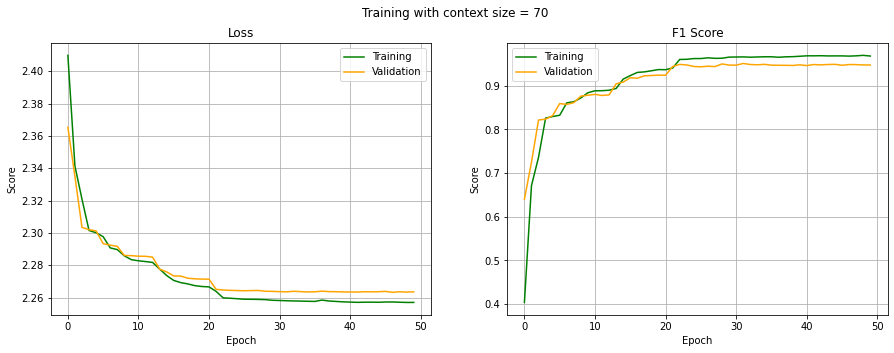

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9690, device='cuda:0'),
 tensor(0.9481, device='cuda:0'),
 tensor(0.9475, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9690, device='cuda:0'),
 tensor(0.9481, device='cuda:0'),
 tensor(0.9475, device='cuda:0'))

## Heatmap

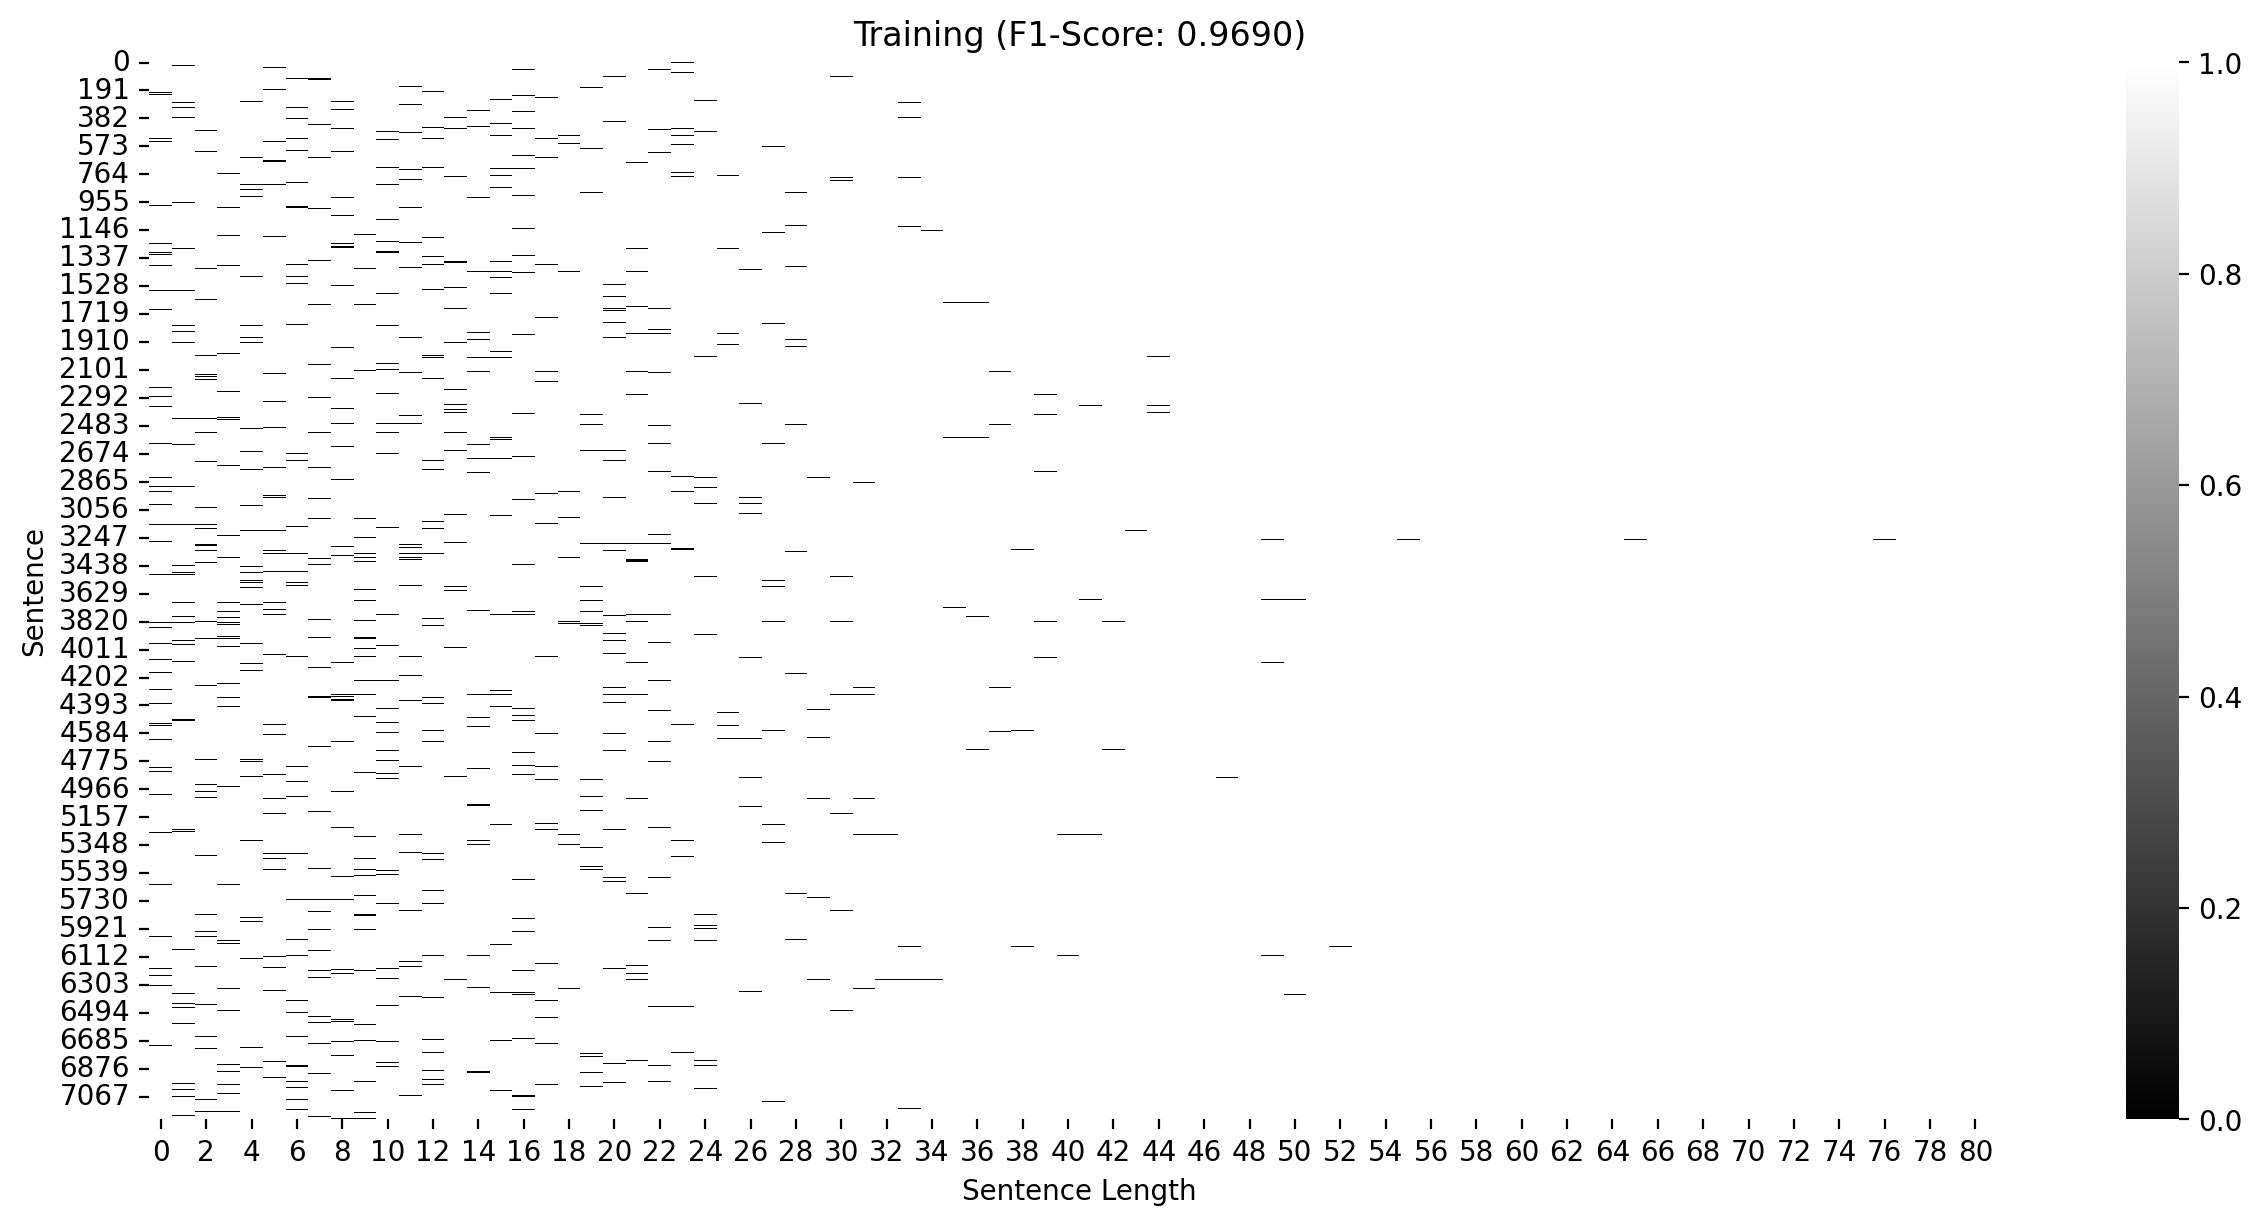

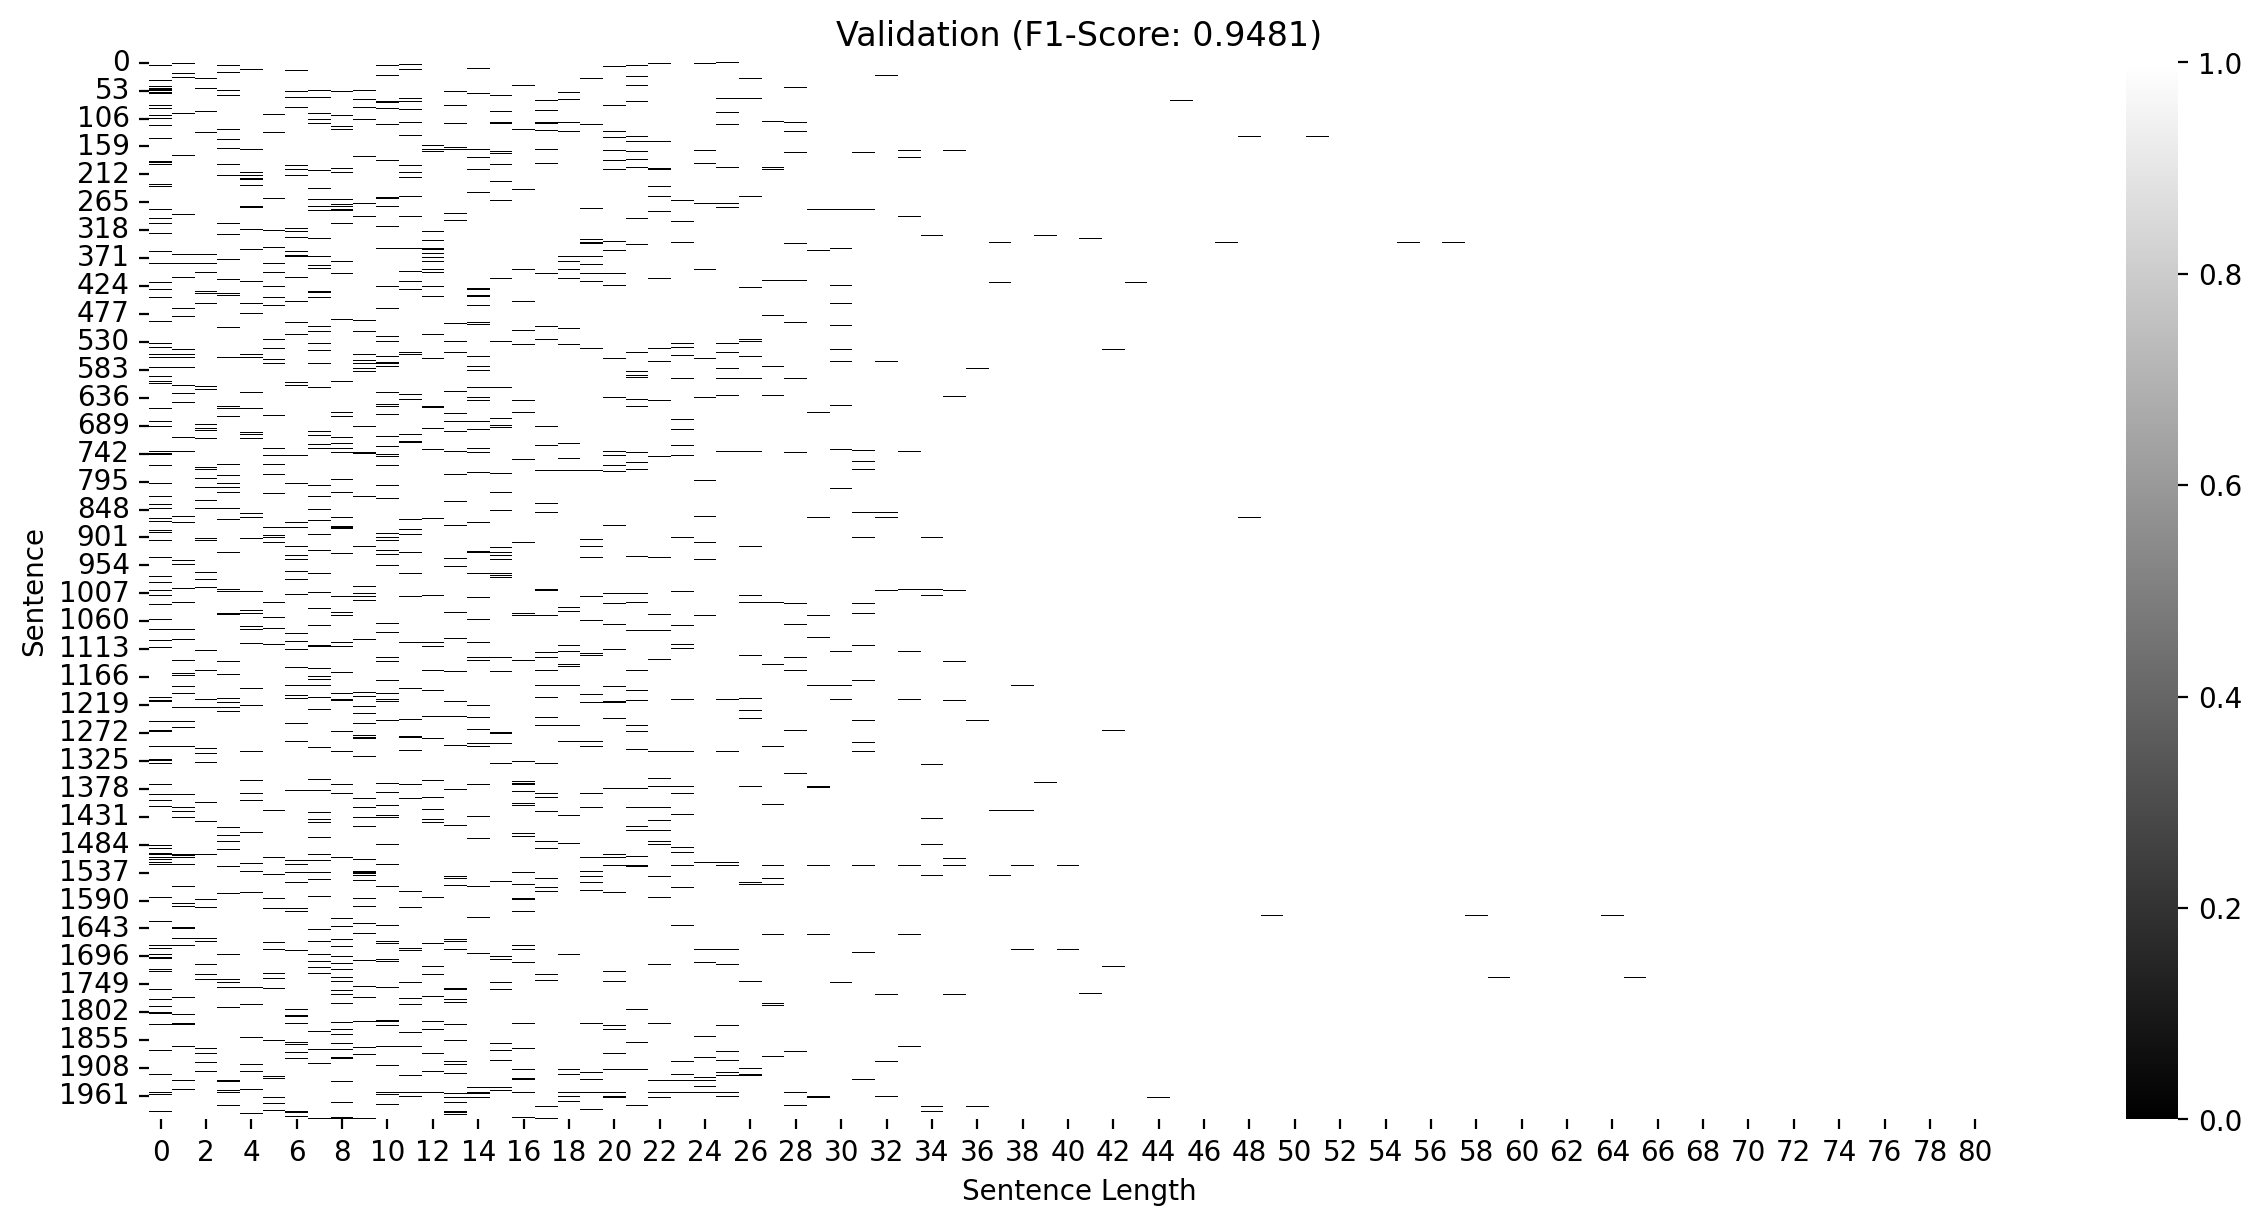

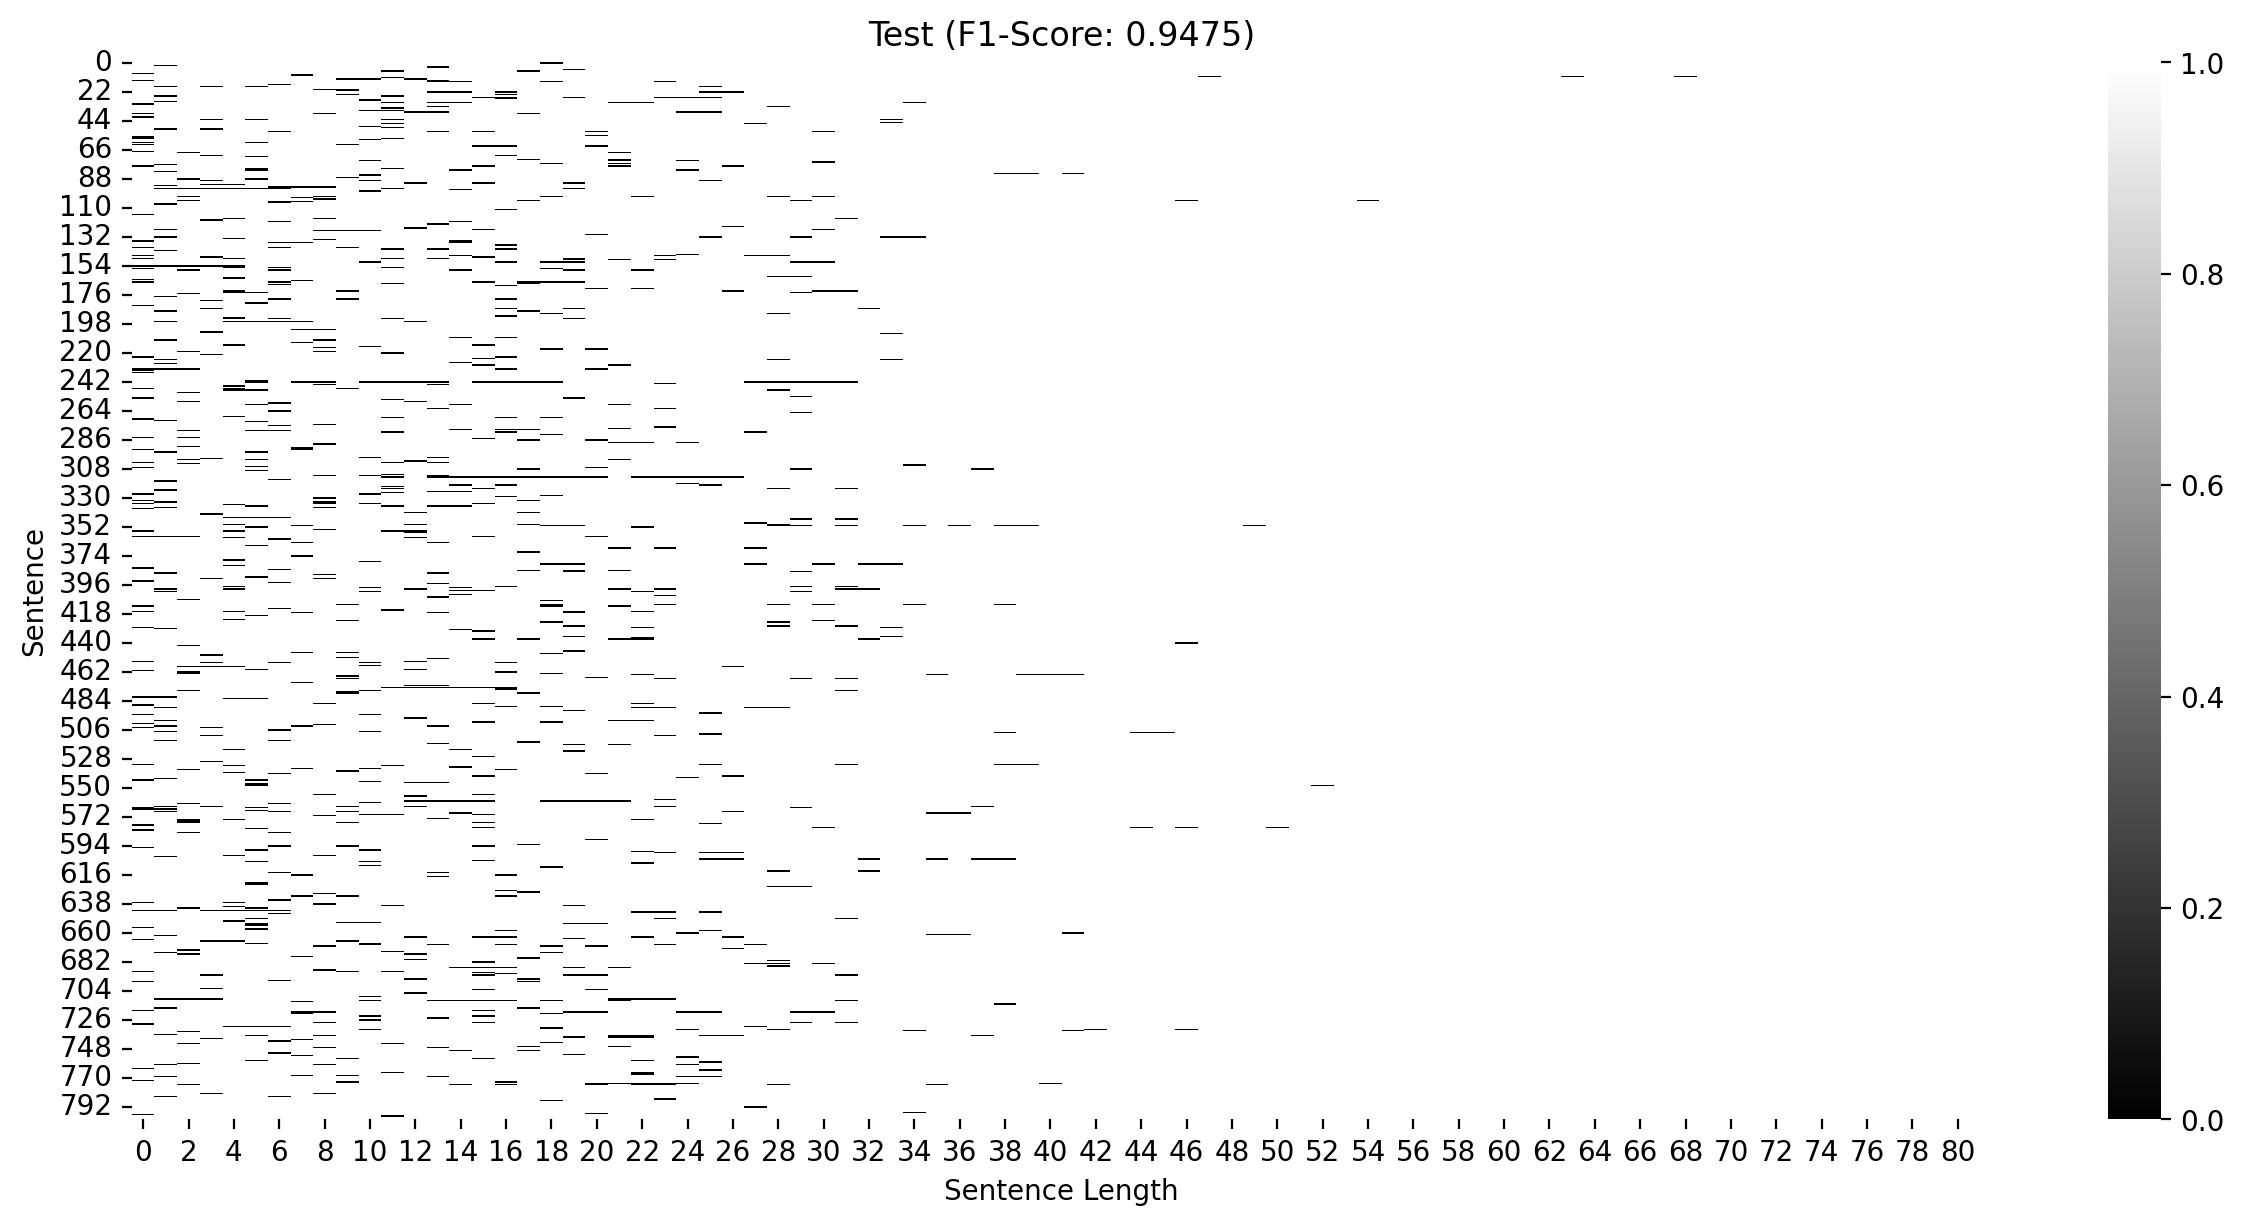

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 96 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


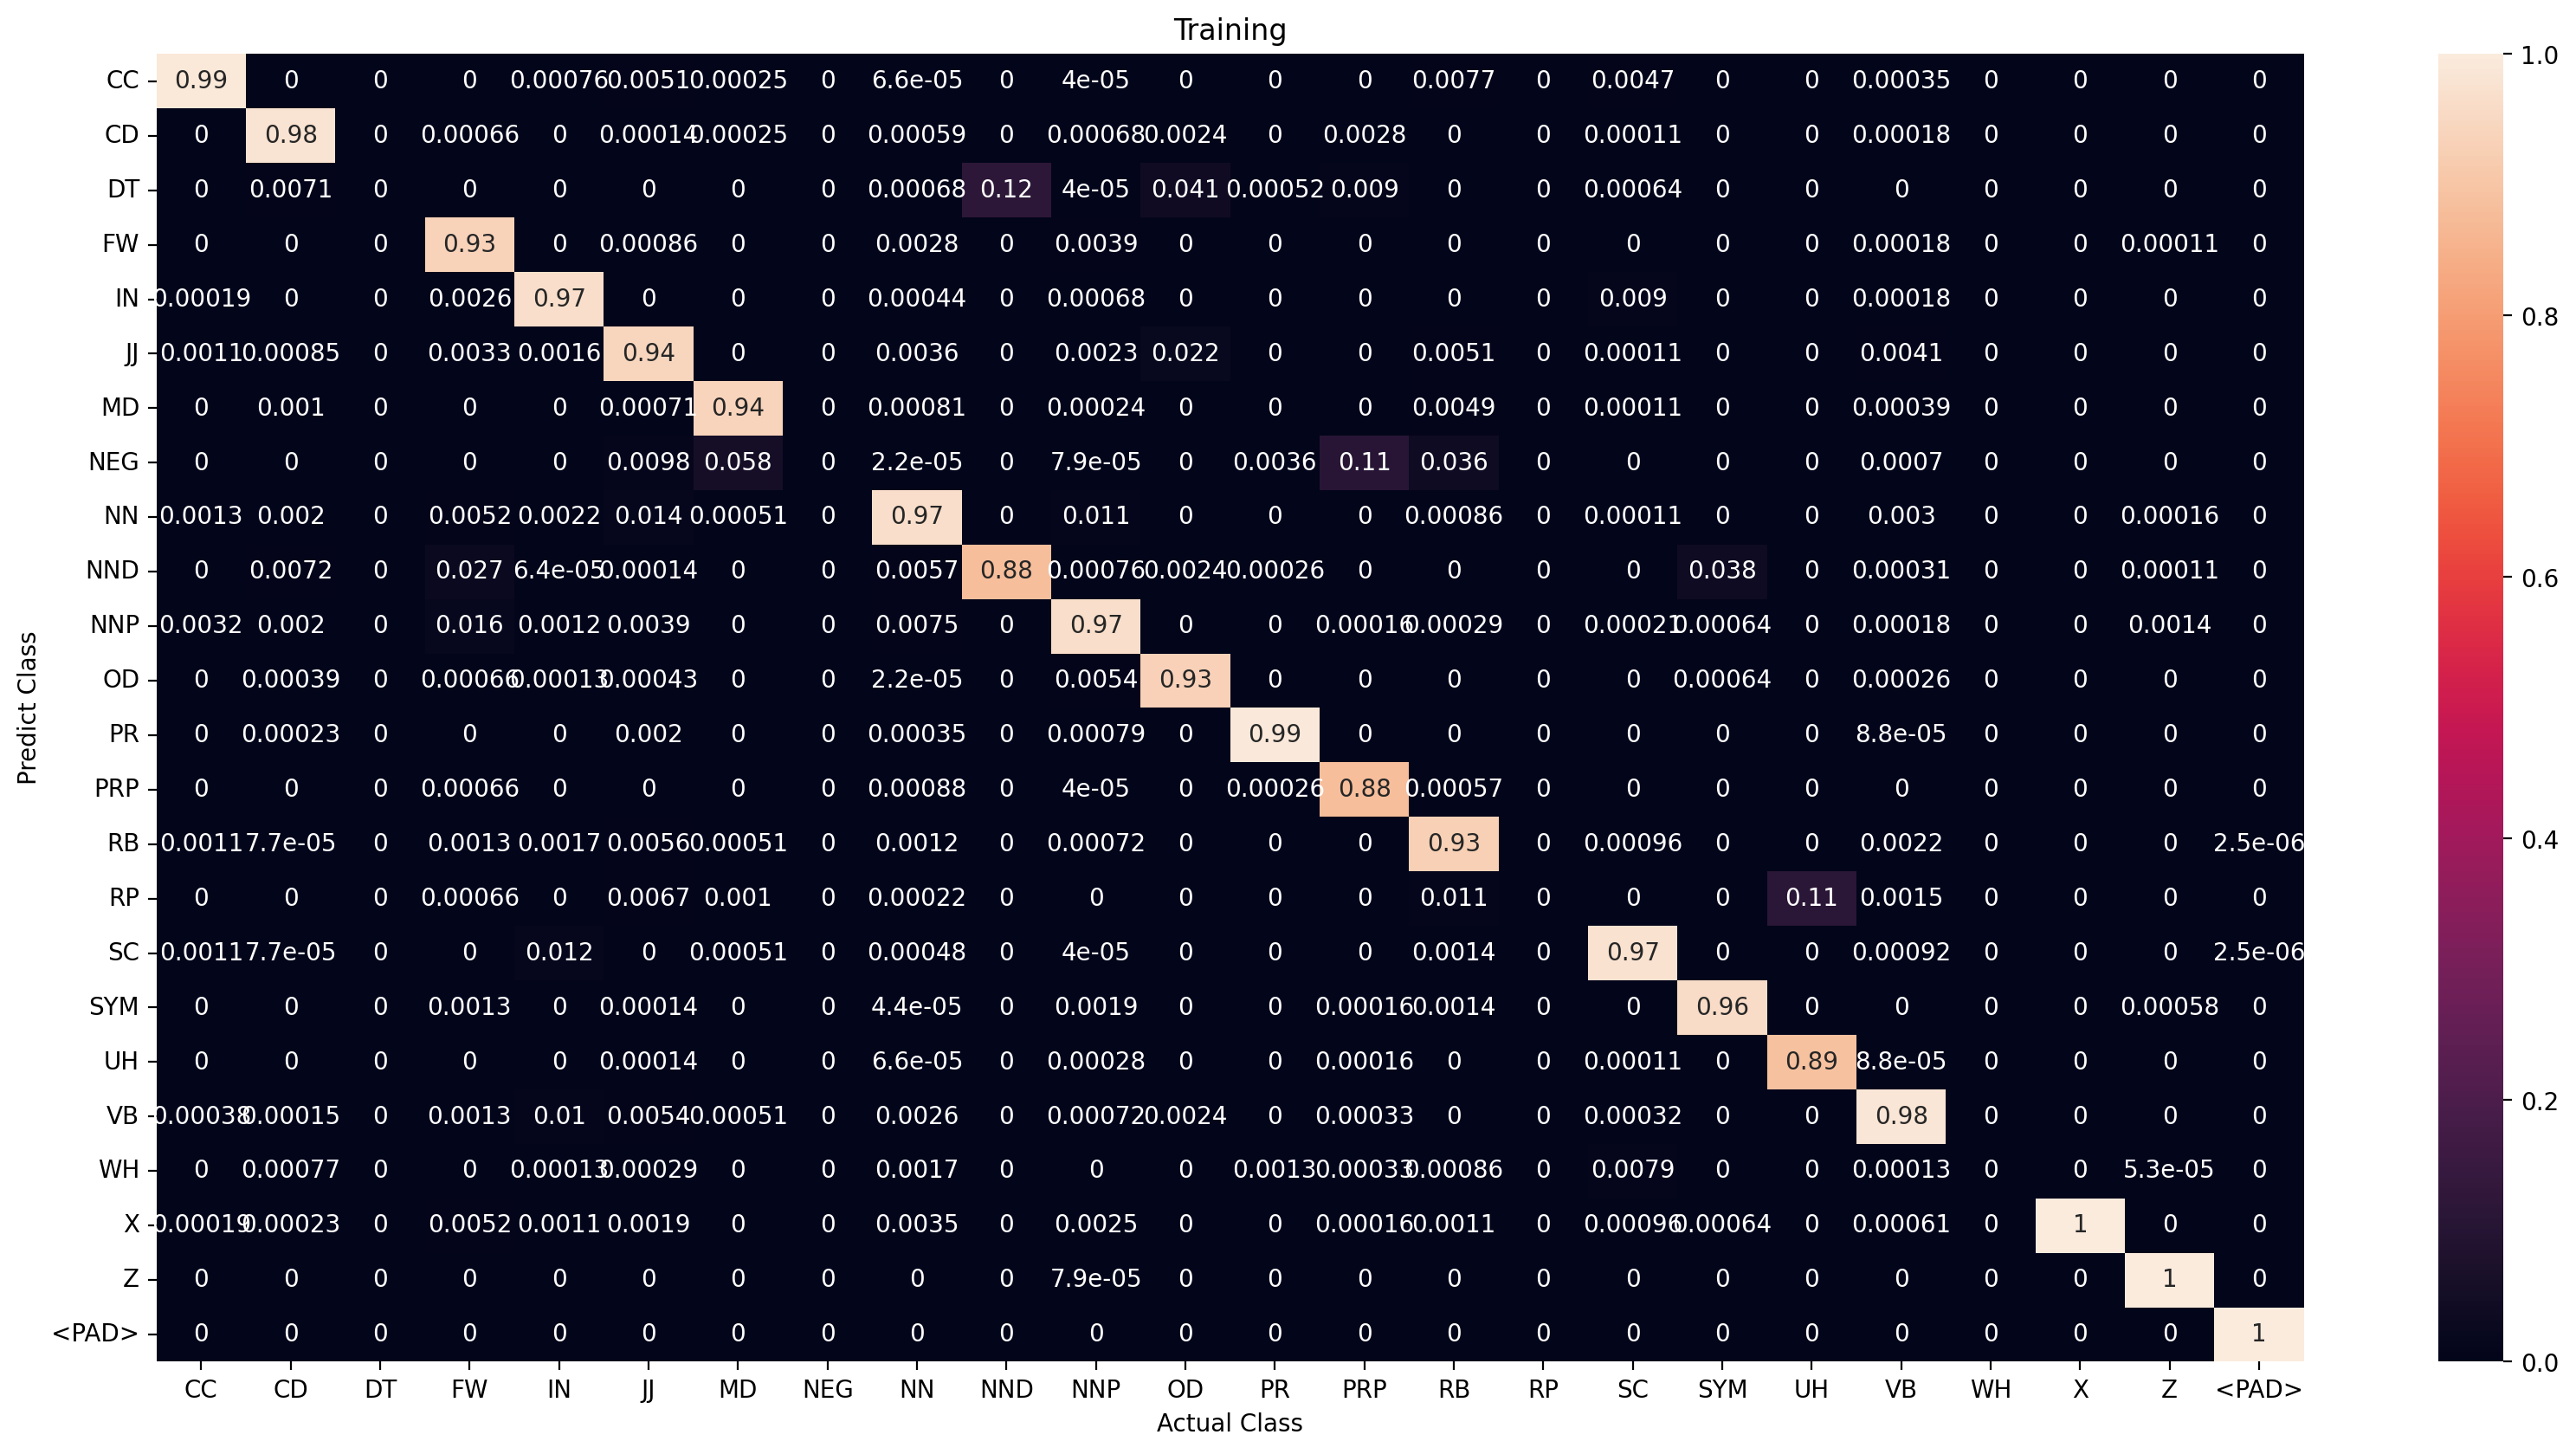

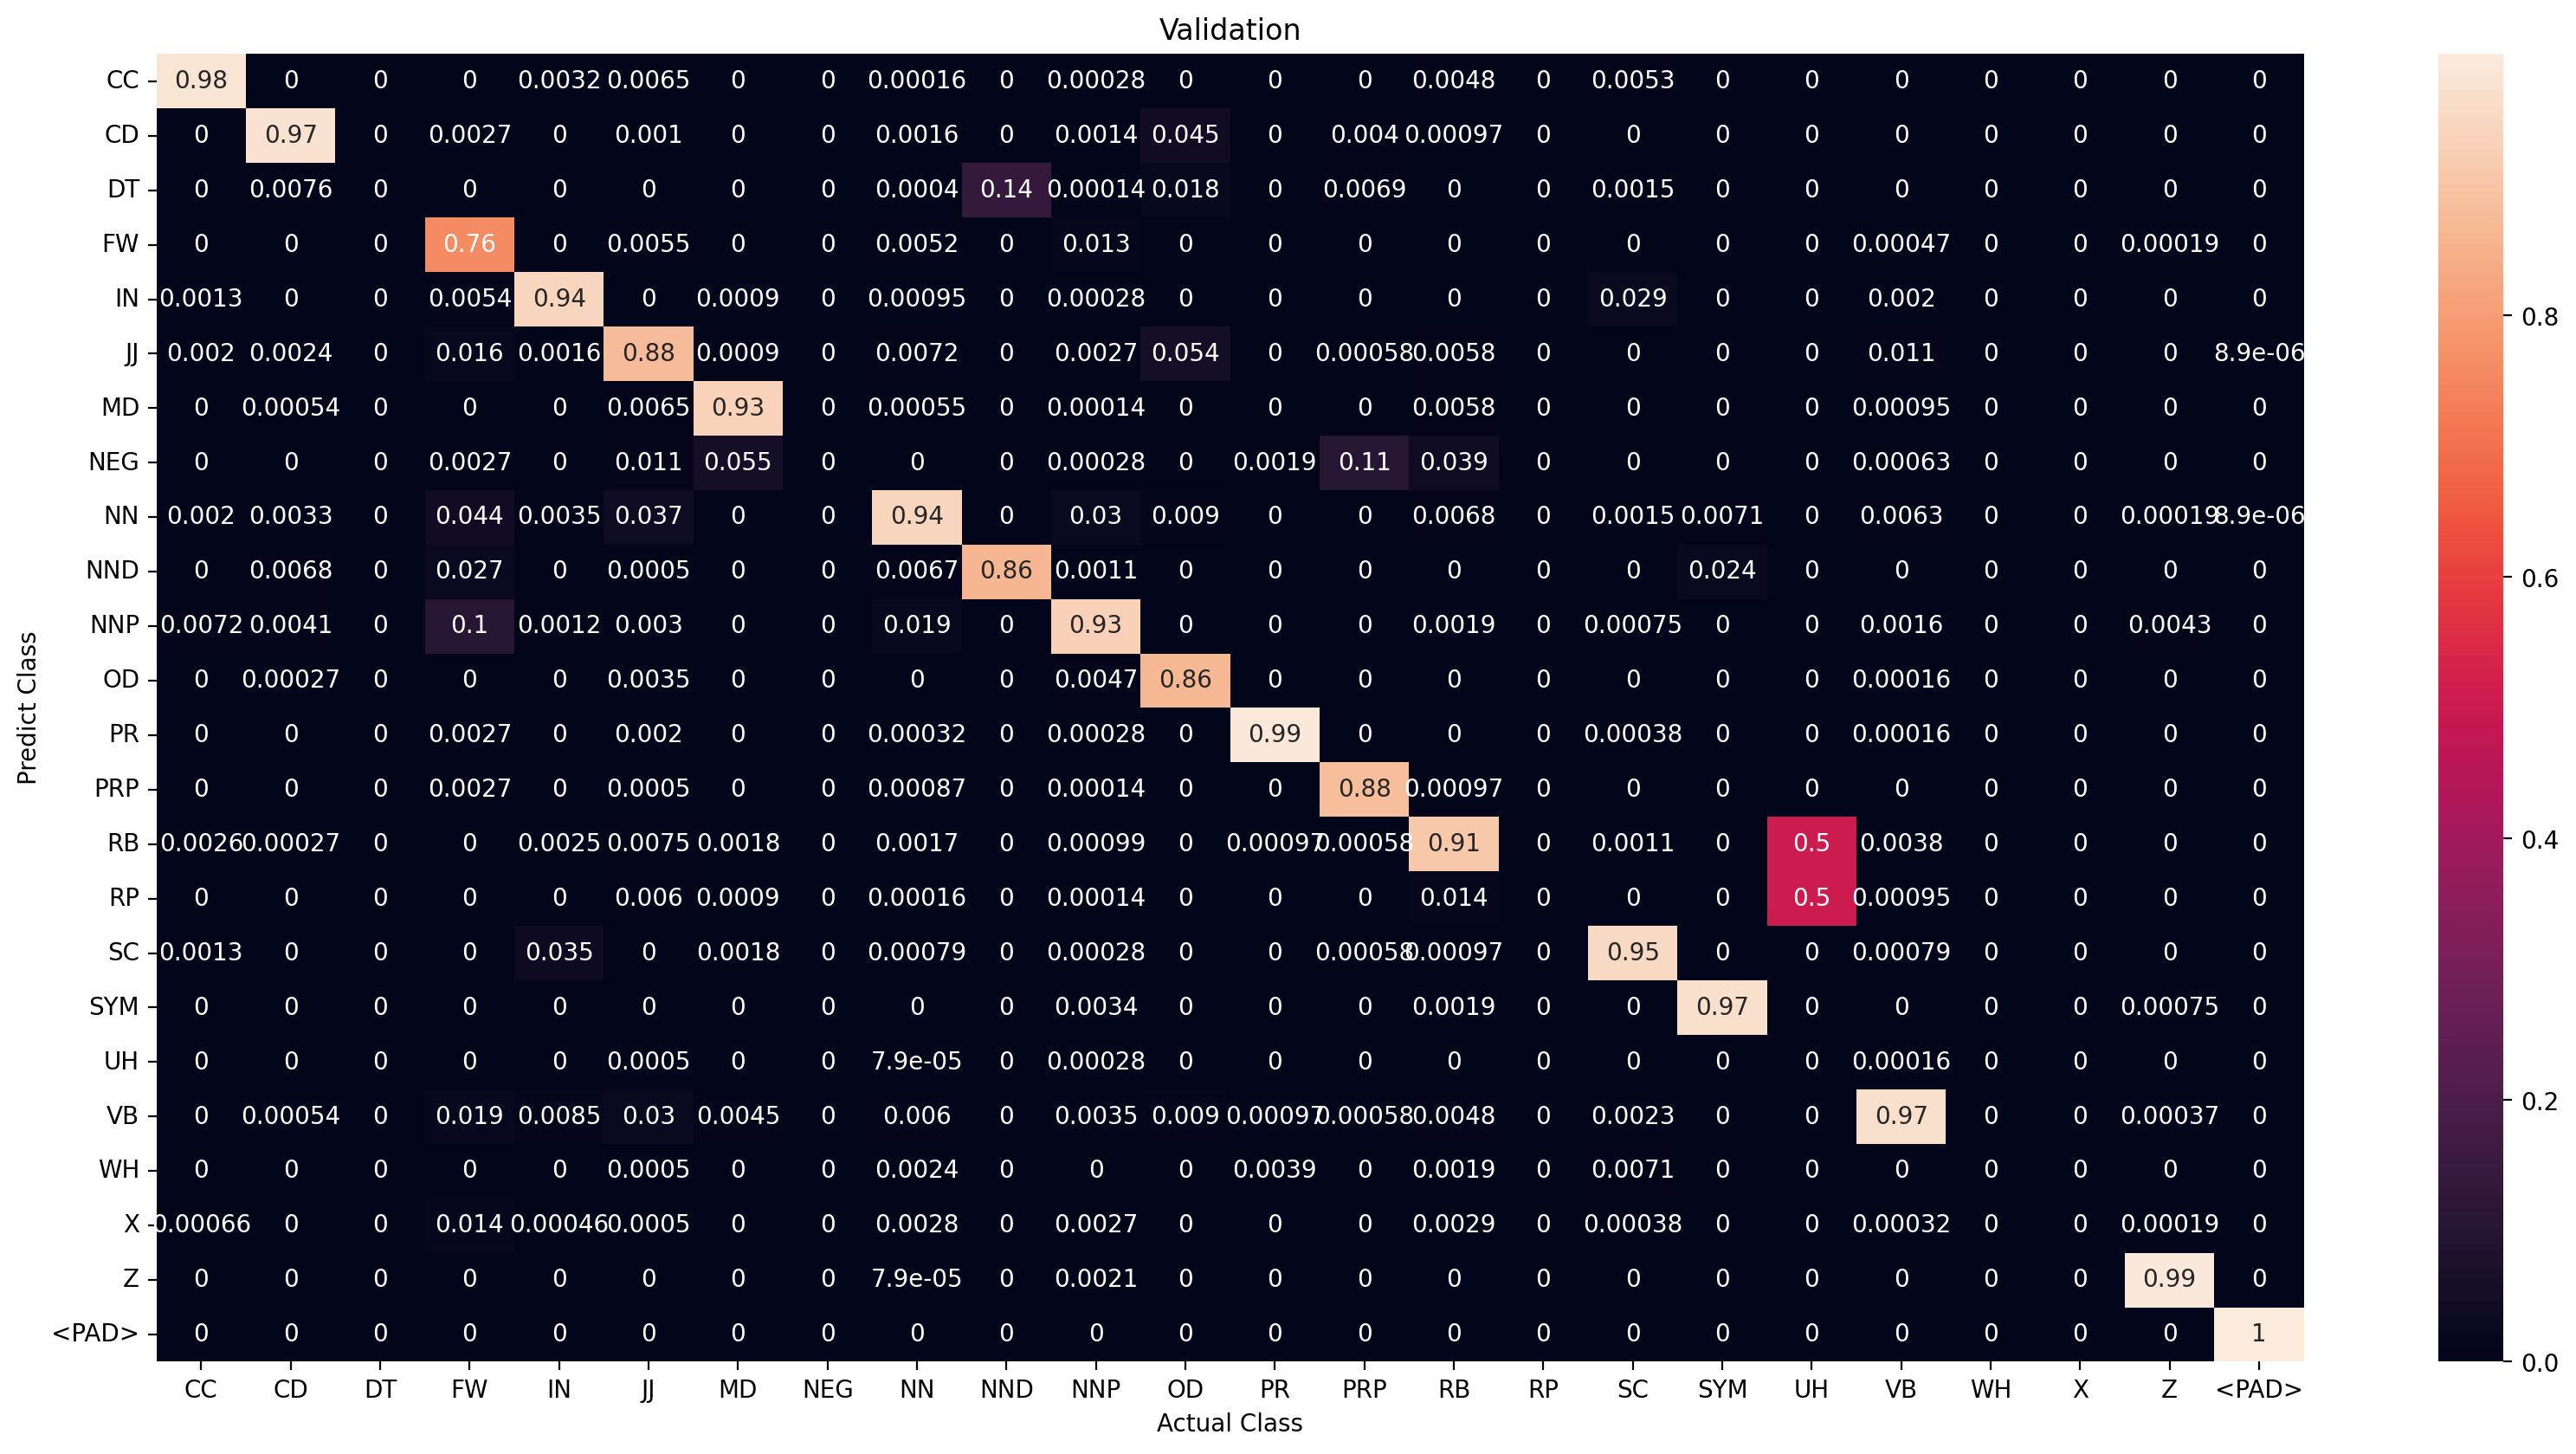

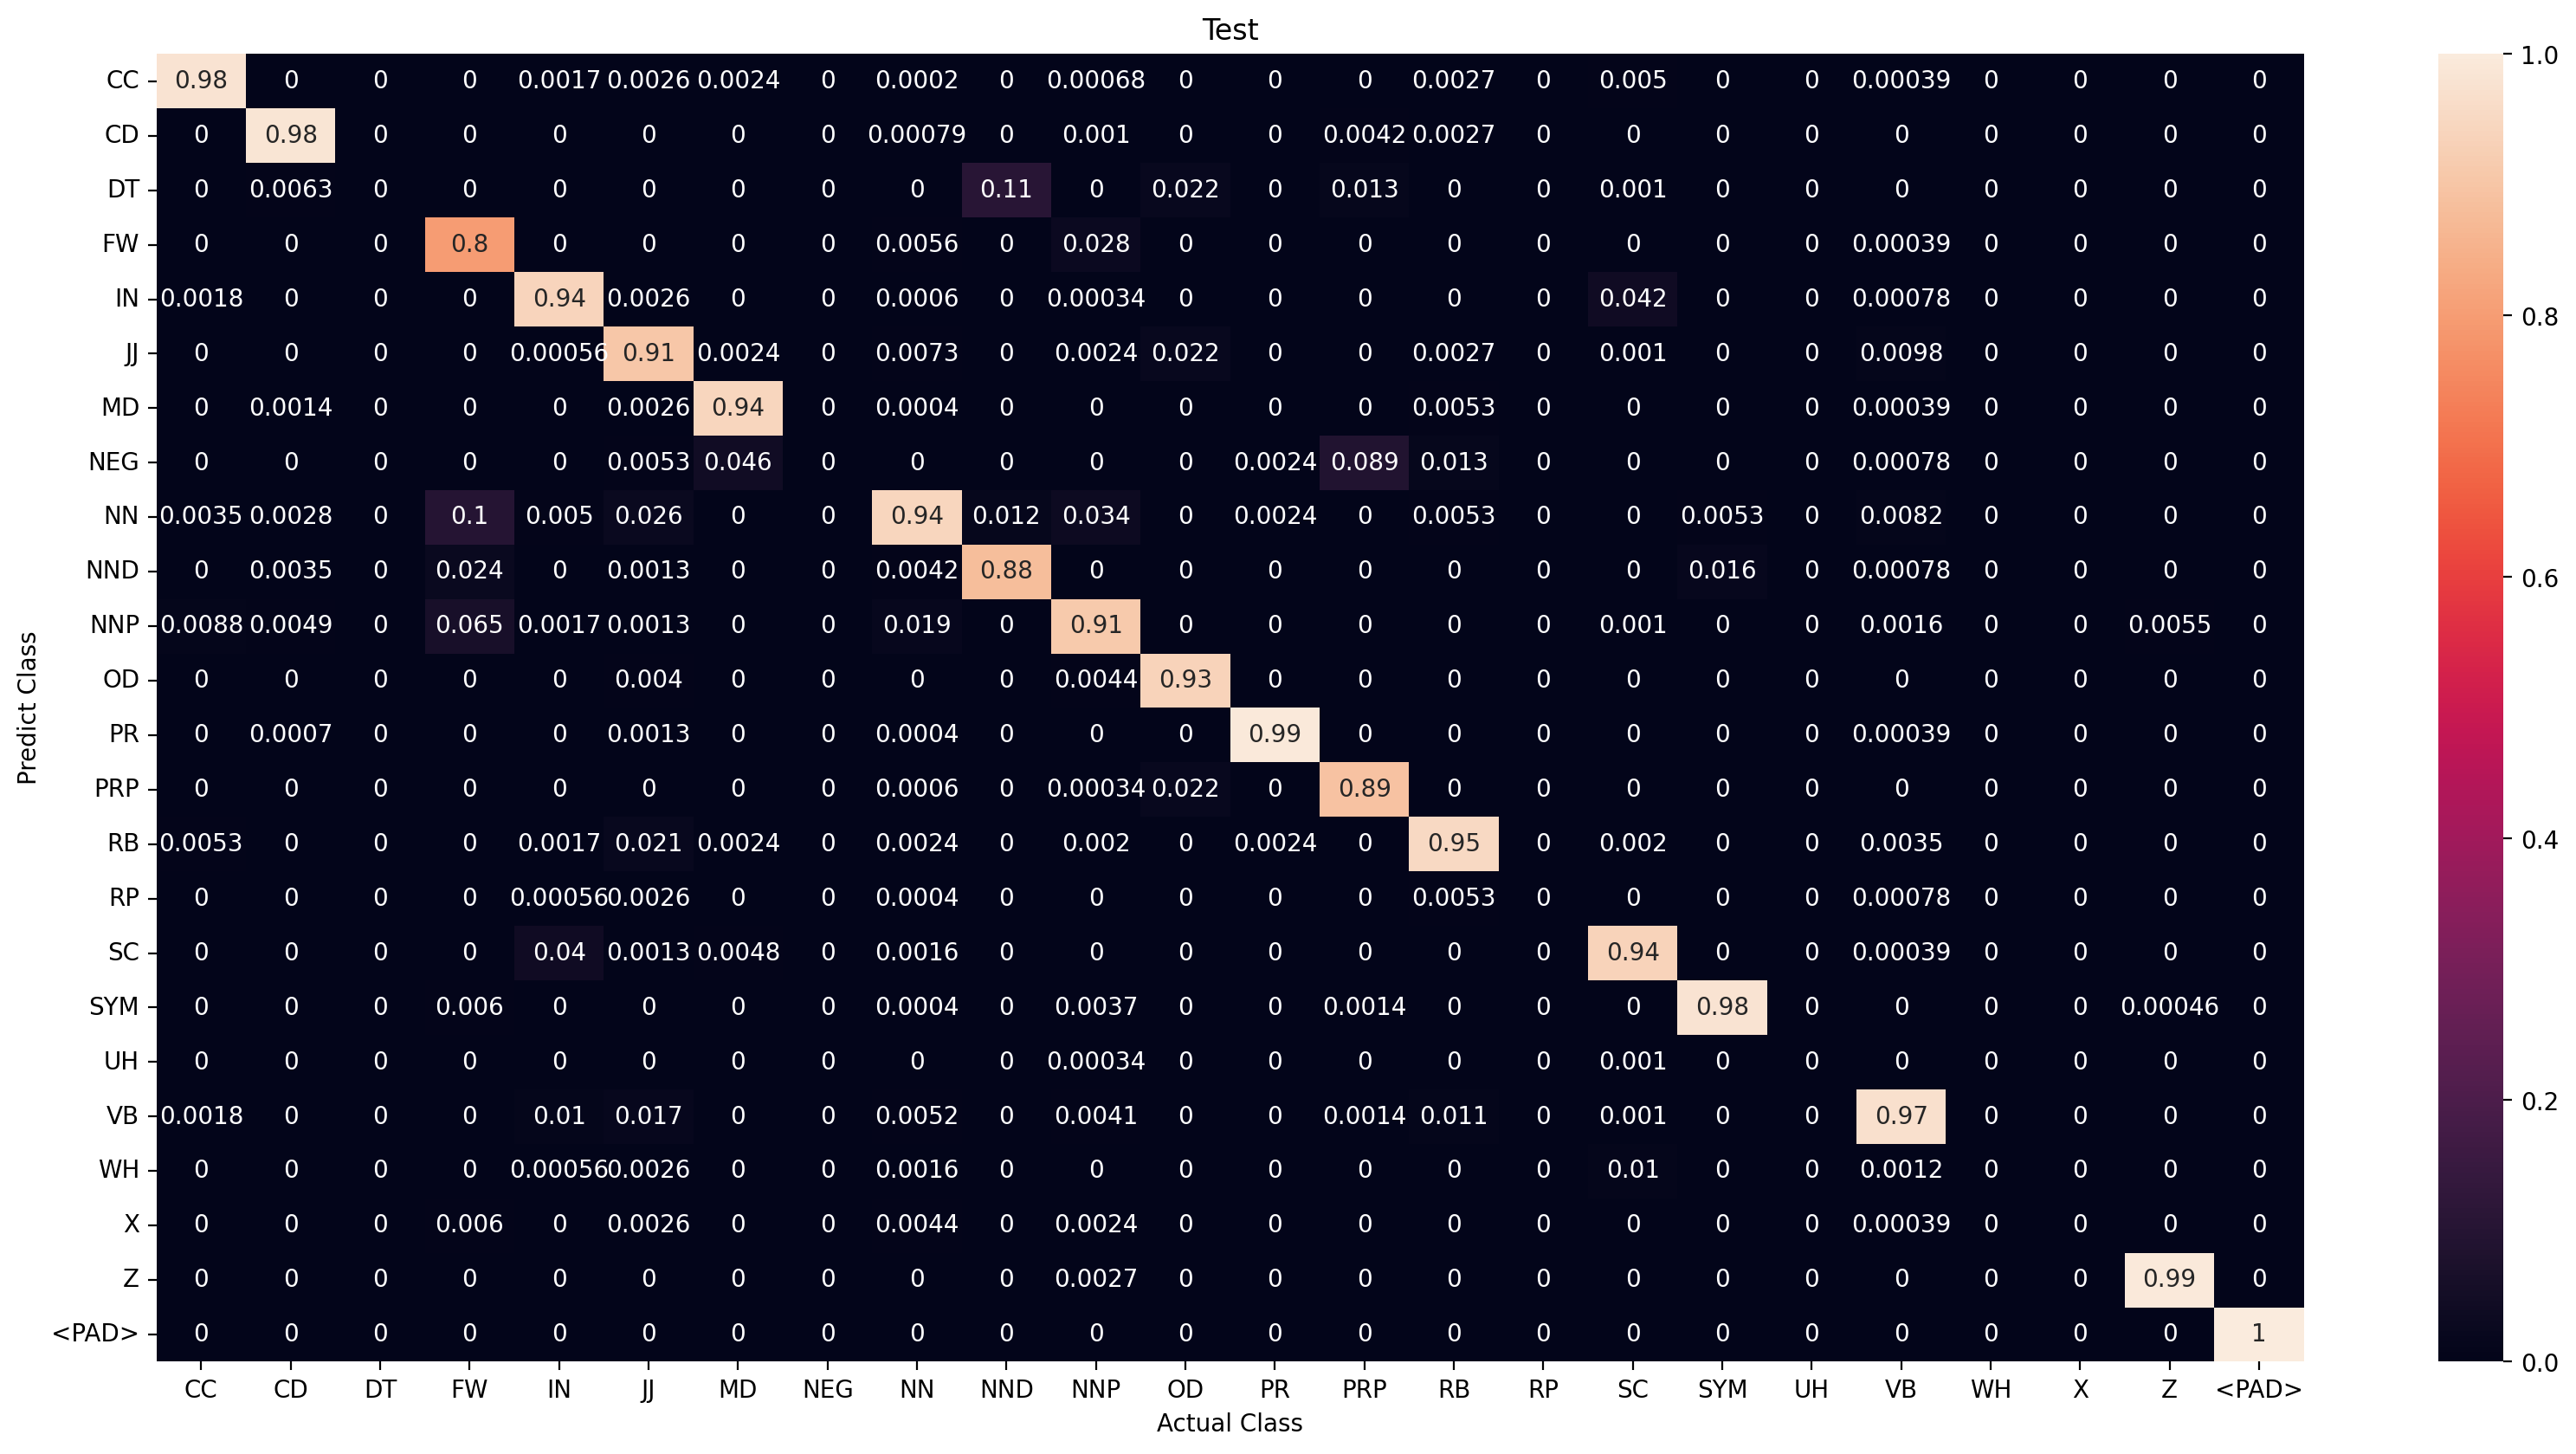

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5190       | CC    : 132      |
| CD    : 12758  | CD    : 12688      | CD    : 70       |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1425       | FW    : 241      |
| IN    : 15371  | IN    : 15241      | IN    : 130      |
| JJ    : 6997   | JJ    : 6608       | JJ    : 389      |
| MD    : 3774   | MD    : 3686       | MD    : 88       |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44144      | NN    : 528      |
| NND   : 1021   | NND   : 535        | NND   : 486      |
| NNP   : 24845  | NNP   : 24354      | NNP   : 491      |
| OD    : 541    | OD    : 387        | OD    : 154      |
| PR    : 3896   | PR    : 3841       | PR    : 55       |
| PRP   : 5408   | PRP   : 5363       | PRP   : 45       |
| RB    : 3463   | RB    : 3252       | RB    : 211      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 11128
Wrong prediction            : 693
Percentage correct oov pred : 94.1375518145673

Validation
Number OOV token            : 3350
Correct prediction          : 2974
Wrong prediction            : 376
Percentage correct oov pred : 88.77611940298507

Test
Number OOV token            : 1391
Correct prediction          : 1232
Wrong prediction            : 159
Percentage correct oov pred : 88.56937455068297



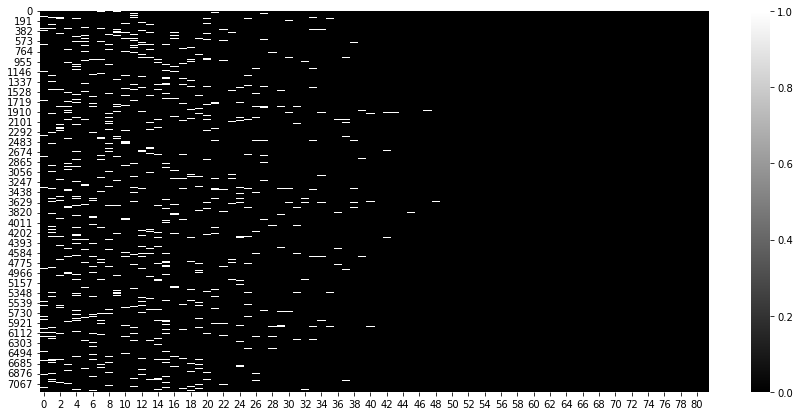

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

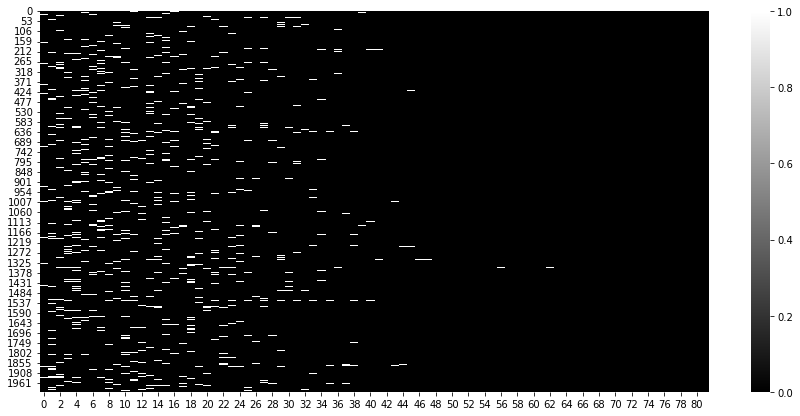

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

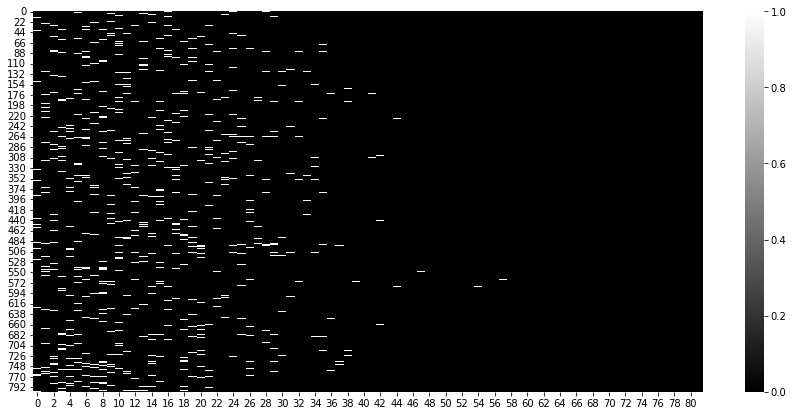

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);